In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.interpolate import griddata
from scipy import interpolate
from scipy.stats.contingency import margins

#The operations on convergence maps are handled with the ConvergenceMap class
from lenstools import ConvergenceMap

import time
import os

/opt/anaconda3/lib/python3.8/site-packages/lenstools/statistics/ensemble.py:943: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  class Panel(pd.Panel):


In [2]:
######################## define constants etc. ############################### 

workPath = '/n/holyscratch01/dvorkin_lab/Users/tianliwang/'
mapPath = workPath+'maps_unzipped/'
# workPath = '/Users/Ed/Desktop/cosm_prjt/'

n_cosmo = 90
n_imagespercosmo = 512  # number of images per cosmology 

# Om_d = 0.311
# si_d = 0.789
Om_d = 0.26
si_d = 0.8

# get the grid for interpolation 
ngrid = 300
xi = np.linspace(0.18, 0.7, ngrid)
yi = np.linspace(0.2, 1.2, ngrid)
Xi, Yi = np.array(np.meshgrid(xi, yi))
grid = np.array([np.ndarray.flatten(Xi), np.ndarray.flatten(Yi)]).T

l_edges = np.logspace(np.log10(100.0), np.log10(3.75e4), 21)
contour_intervals = np.array([0.95, 0.680, 0.01])    # percentage contour levels 
n_integralsteps = 1000   # interpolation steps in the integral for contours 

In [3]:
def read_parametersfromfile(path):
    '''
    Input: string for the directory to the folders of cosmology 
    
    Function: reads the Omega_m and sigma_8 values from the folder names in 
    the path directory and store them as arrays of strings. Stores the values 
    as strings to avoid rounding, for example, 0.600 to 0.6. 
    
    Output: (array of strings of Omega_m, array of strings of sigma_8)
    '''
    
    Om_strings = [] 
    si_strings = []
    
    for filename in os.listdir(path):
        if (filename.startswith('Om') and not filename.endswith('.gz')): 
            Om_strings.append(filename[2:7]) 
            si_strings.append(filename[10:15])
            
    return Om_strings, si_strings


def get_pls(path, Om, si, l_edges, i_start, i_end):
    '''
    Input: path to the maps (string), omegam and sigma8 value for the maps (floats), 
    l edges for power spectrum (array), start index and end index for reading the images (ints)
    
    Function: get the power spectra for all the maps using ConvergenceMap in LensTools with the 
    input l_edges 
    
    Output: l, matrix of power spectra of dimension (i_end+1-i_start)x(l_edges-1) (each row for one map)
    
    '''
    
    Pls = [] 
    
    for i in range(i_start, i_end+1): 
        if (i < 10): filenum = '00{}'.format(i)
        elif (i < 100): filenum = '0{}'.format(i)
        else: filenum = i 
        
        map_filename = '{}Om{}_si{}/WLconv_z1.00_0{}r.fits'.format(path, Om, si, filenum)
        conv_map = ConvergenceMap.load(map_filename)
        
        # Measure the power spectrum calling the powerSpectrum method
        l, Pl = conv_map.powerSpectrum(l_edges)
        
        Pls.append(Pl)
        
    return l, Pls

def get_pcs(path, Om, si, n_bins, i_start, i_end):
    '''
    Input: path to the maps (string), omegam and sigma8 value for the maps (floats), 
    # bins for peak counts (int), start index and end index for reading the images (ints)
    
    Function: get the peak counts for all the maps using ConvergenceMap in LensTools with the 
    input n_bins 
    
    Output: matrix of peak counts of dimension (i_end+1-i_start)x(n_bins-1) (each row for one map)
    
    '''
    
    peakcounts = [] 
    
    for i in range(i_start, i_end+1): 
        if (i < 10): filenum = '00{}'.format(i)
        elif (i < 100): filenum = '0{}'.format(i)
        else: filenum = i 
        
        map_filename = '{}Om{}_si{}/WLconv_z1.00_0{}r.fits'.format(path, Om, si, filenum)
        conv_map = ConvergenceMap.load(map_filename)
        
        # Measure the peak count by calling methods in ConvegenceMap 
        std = conv_map.std()
        thresholds = np.linspace(conv_map.data.min()/std, conv_map.data.max()/std, n_bins)
        nu, peaks = conv_map.peakCount(thresholds, True)
        
        peakcounts.append(peaks)
        
    return peakcounts


def get_p(Pls, d): 
    '''
    Input: matrix of power spectra of dimension (# maps)x(n_lbins) and the 
    discriptor array (mean power spec of one chosen cosmo)
    
    Function: calculates the posterior value for the given d 
    
    Output: scalar probability 
    '''
    
    N = len(Pls)    # number of maps 
    
    mu = np.mean(Pls, axis=0)
    assert len(mu) == len(Pls[0])   # check if taking mean along correct dimension 
    
    cov = np.cov(np.array(Pls).T)
    covinv = np.linalg.inv(cov)
    covinv = (N-len(mu)-2)/(N-1) * covinv  # debias the cov inverse 
    
    exponent = -0.5*np.dot(d-mu, np.dot(covinv, d-mu))
    
    return np.exp(exponent)


def get_interpstats(origdata, origpoints, grid_interp, if_getcovdet): 
    '''
    Input: 
    origdata: ndarray with shape (# points in parameter space)x(# measurements per point)x(# variables per measurement)
    origpoints: ndarray with shape (# points in parameter space)x(# axese)
    grid_interp: ndarray with each row being a coordinate tuple for one point in parameter space (n,)
    if_getcovdet: boolean for whether to return cov matrix determinants 
    
    Function: Linearly interpolate the means and unbiased inverse covariance matrices for each point specified in 
    grid_interp through the griddata function using measurements provided by origdata, which are data 
    at points in parameter space specified by origpoints. 
    
    Output: interpolated means, interpolated inverse covaraince matrices, (interpolated cov determinants) each of 
    dimension (m,)
    '''
    
    assert len(origdata) == len(origpoints), 'dimension of origdata does not match dimension of origpoints'
    
    # get dimensions of input data
    N_data = len(origdata)
    N_measurements = len(origdata[0])
    N_vars = len(origdata[0][0])
    
    # take the mean of all measurements of each point 
    mus = np.mean(origdata, axis=1) 
    
    if (if_getcovdet): cov_list = []
    covinv_list = []
    
    # calculate the cov matrices 
    for i in range(N_data): 
        cov = np.cov(origdata[i].T)
        if (if_getcovdet): cov_list.append(cov)
        covinv = np.linalg.pinv(cov)*(N_measurements-N_vars-2)/(N_measurements-1)   # debias cov inverse; using pinv 
        covinv_list.append(covinv)
        
    # linear interpolation 
    mus_interp = griddata(origpoints, mus, grid_interp, method='linear')
    covinvs_interp = griddata(origpoints, covinv_list, grid_interp, method='linear')
    
    if (if_getcovdet): 
        covdets = np.linalg.det(cov_list)
        covdets_interp = griddata(origpoints, covdets, grid_interp, method='linear')
        return mus_interp, covinvs_interp, covdets_interp
    
    return mus_interp, covinvs_interp 


def get_Ps(mus, covinvs, d, *args): 
    '''
    Input: 
    mus: ndarray of means of shape (n, m); n is the number of points in parameter space 
    covinvs: ndarray of covariance inverses (n, m, m)
    d: ndarry of the mean at descriptor point in parameter space of shape (m,)
    *args: optional argument of cov determinants 
    
    Function: calculates the normalized Gaussian probabilities for the ith point in parameter 
    space using mus[i] and covinv[i], the descriptor d and optional array of cov 
    determinants (shape (n,)) in *args 
    
    Output: 1D array of probabilities of shape (n,)
    '''
    
    assert len(mus) == len(covinvs), 'dimensions of mus and covinvs do not match in axis=0'
    assert len(mus[0]) == len(covinvs[0]), 'dimensions of mus and covinvs do not match in axis=1'
    assert len(args) < 2, 'expecting only 1 optional argument'
    
    if (args): covdets = args[0]
    
    # get the exponents 
    exponents = [] 

    for i in range(len(mus)): 
        vec_temp = d - mus[i]
        exponents.append(-0.5*np.dot(vec_temp, np.dot(covinvs[i],vec_temp.T))) 
    
    # calculate the probabilities 
    if (args): Ps = 1.0/(covdets**0.5)*np.exp(exponents)
    else: Ps = np.exp(exponents)
        
    # mask the nan values with 0 
    Ps[np.isnan(Ps)] = 0
        
    # normalize
    norm_factor = np.sum(Ps)
    Ps = Ps/norm_factor
    
    return Ps 


def get_contours(Ps, intervals, n):
    '''
    Input: 
    Ps: 1D array of probabilities 
    intervals: 1D array of the percentages for which to calculate the contours 
    n (integer): # bins to integrate the Ps over 
    
    Output: array of probabilities at which to draw the contours corresponding to the percentages in intervals; 
    has the same shape as intervals. 
    '''
    
    assert np.max(Ps) <= 1.0, 'Probabilities > 1 and may be unnormalized'
    
    t = np.linspace(0, np.max(Ps), n)  # intervals for doing the integrals 
    integrals = ((Ps >= t[:, None, None]) * Ps).sum(axis=(1,2))

    f = interpolate.interp1d(integrals, t)
    t_contours = f(intervals)
    
    return t_contours 

## Load and process data for CNN 

In [4]:
data_cnn = np.genfromtxt(workPath+'fullNet_testing_shuffle.dat', names=True, dtype=None)

Om_pred = data_cnn['Om_pred']
si_pred = data_cnn['si_pred']
Om_expect = data_cnn['Om_expect']
si_expect = data_cnn['si_expect']

# list of Oms and sis of our data 
Oms_list = Om_expect[::len(Om_expect)//n_cosmo]
sis_list = si_expect[::len(Om_expect)//n_cosmo]

In [5]:
# prepare data 
d_cnn = np.array([Om_d, si_d])
origdata_cnn = np.reshape(np.array([Om_pred, si_pred]).T, (n_cosmo, 128, -1))
points_cnn = np.array([Oms_list, sis_list]).T

# get the statistics 
mus_cnn, covinvs_cnn, covdets_cnn = get_interpstats(origdata_cnn, points_cnn, grid, True)
Ps_cnn = get_Ps(mus_cnn, covinvs_cnn, d_cnn, covdets_cnn)
contours_cnn = get_contours(Ps_cnn, contour_intervals, n_integralsteps)

## Load and process data for power spectrum

In [6]:
data_spec = np.load(workPath+'spectra.npy').astype(np.float)

In [7]:
# prepare data   
origdata_spec = np.reshape(data_spec[2:, :].T, (n_cosmo, n_imagespercosmo, -1))
points_spec = data_spec[:2].T
# find the index for the chosen center Om and si 
condition = (points_spec[:,0] == d_cnn[0])*(points_spec[:,1] == d_cnn[1])
d_index = np.where(condition)[0][0]
d_spec = np.mean(origdata_spec[d_index], axis=0) 

# exclude the cosmo with d_index
origdata_spec_no_d = np.array([origdata_spec[i] for i in range(n_cosmo) if i!=d_index])
points_spec_no_d = np.array([points_spec[i] for i in range(n_cosmo) if i!=d_index])

# get the statistics 
mus_spec, covinvs_spec = get_interpstats(origdata_spec_no_d, points_spec_no_d, grid, False)
# mus_spec, covinvs_spec = get_interpstats(origdata_spec, points_spec, grid, False)
Ps_spec = get_Ps(mus_spec, covinvs_spec, d_spec)
contours_spec = get_contours(Ps_spec, contour_intervals, 1000)

## Load and process data for peak count

In [8]:
data_peak = np.load(workPath+'peakcounts_fixedrange_2.npy').astype(np.float)

In [9]:
# prepare data   
origdata_peak = np.reshape(data_peak[2:, :].T, (n_cosmo, n_imagespercosmo, -1))
points_peak = data_peak[:2].T
# find the index for the chosen center Om and si 
condition_peak = (points_peak[:,0] == d_cnn[0])*(points_peak[:,1] == d_cnn[1])
d_index_peak = np.where(condition_peak)[0][0]
d_peak = np.mean(origdata_peak[d_index_peak], axis=0) 

# exclude the cosmo with d_index
origdata_peak_no_d = np.array([origdata_peak[i] for i in range(n_cosmo) if i!=d_index_peak])
points_peak_no_d = np.array([points_peak[i] for i in range(n_cosmo) if i!=d_index_peak])

# get the statistics 
mus_peak, covinvs_peak = get_interpstats(origdata_peak_no_d, points_peak_no_d, grid, False)
Ps_peak = get_Ps(mus_peak, covinvs_peak, d_peak) # still using diff cov, not the one from the fiducial cosmo for all Ps
contours_peak = get_contours(Ps_peak, contour_intervals, 1000)

## Contour and marginal plot

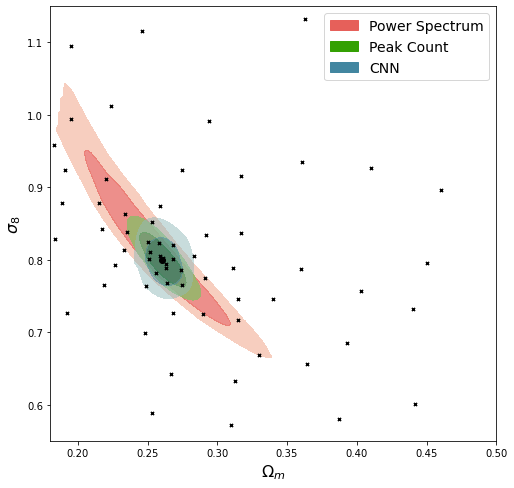

In [17]:
o_min = 0.18
o_max = 0.5 
s_min = 0.55
s_max = 1.15
fig = plt.figure(figsize=[8,8])
plt.contourf(xi, yi, np.reshape(Ps_spec, (ngrid, ngrid)), contours_spec, colors=['#F4BAA5', '#E6605A'], alpha=0.7)
plt.contourf(xi, yi, np.reshape(Ps_peak, (ngrid, ngrid)), contours_peak, colors=['#7fc263', '#287904'], alpha=0.7)
plt.contourf(xi, yi, np.reshape(Ps_cnn, (ngrid, ngrid)), contours_cnn, colors=['#93BABA', '#4286A0'], alpha=0.5)
plt.scatter(d_cnn[0], d_cnn[1], color='black')
plt.scatter(Oms_list, sis_list, marker='x', color='black', s=10)
plt.xlim(o_min, o_max)
plt.ylim(s_min, s_max)
plt.xlabel(r'$\Omega_m$', fontsize=16)
plt.ylabel(r'$\sigma_8$', fontsize=16)

leg_spec = mpatches.Patch(color='#E6605A', label='Power Spectrum')
leg_peak = mpatches.Patch(color='#34a003', label='Peak Count')
leg_net =  mpatches.Patch(color='#4286A0', label='CNN')
plt.legend(handles=[leg_spec, leg_peak, leg_net], fontsize=14)

In [18]:
# get the marginal distributions 
simarginal_cnn, Ommarginal_cnn = margins(np.reshape(Ps_cnn, (ngrid, ngrid)))
simarginal_spec, Ommarginal_spec = margins(np.reshape(Ps_spec, (ngrid, ngrid)))
simarginal_peak, Ommarginal_peak = margins(np.reshape(Ps_peak, (ngrid, ngrid)))

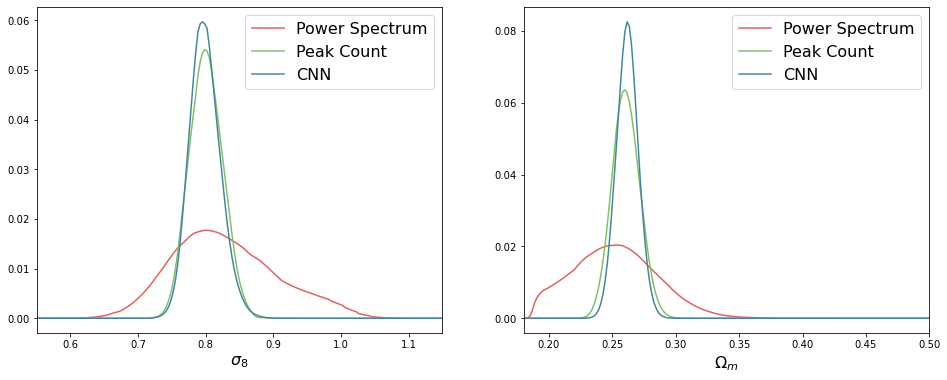

In [19]:
f = plt.figure(figsize=(16,6))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)

ax1.plot(yi, simarginal_spec, label='Power Spectrum', color='#E6605A')
ax1.plot(yi, simarginal_peak, label='Peak Count', color='#7fc263')
ax1.plot(yi, simarginal_cnn, label='CNN', color='#4286A0')
ax1.set_xlabel(r'$\sigma_8$', fontsize=16)
ax1.set_xlim(s_min, s_max)
ax1.legend(fontsize=16)

ax2.plot(xi, Ommarginal_spec[0], label='Power Spectrum', color='#E6605A')
ax2.plot(xi, Ommarginal_peak[0], label='Peak Count', color='#7fc263')
ax2.plot(xi, Ommarginal_cnn[0], label='CNN', color='#4286A0')
ax2.set_xlabel(r'$\Omega_m$', fontsize=16)
ax2.set_xlim(o_min, o_max)
ax2.legend(fontsize=16)

## Calculate and save peak count

In [ ]:
## Calculate and save peak countmapPath = workPath+'maps_unzipped/'
Oms_all, sis_all = read_parametersfromfile(mapPath)
Oms = Oms_all[:n_cosmo]
sis = sis_all[:n_cosmo]

peaks = []

for i in range(n_cosmo): 
    pcs = get_pcs(mapPath, Oms[i], sis[i], 21, 1, n_imagespercosmo)
    flatpcs = np.ndarray.flatten(np.array(pcs))
    peaks = peaks + flatpcs.tolist()
    
peaks = np.reshape(peaks, (n_cosmo, -1)).T
peaksWithLabels = np.concatenate(([np.array(Oms), np.array(sis)], peaks), axis=0)

#np.save(workPath+'peakcounts.npy', peaksWithLabels)